<a href="https://colab.research.google.com/github/sai8e/StockMarketProject/blob/main/Jonathan_Nope_Using_Python_%26_Machine_Learning_to_Predict_Stock_Prices_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Description: This Program uses an artifical recurrent neural network called Long Short Term Memory (LSTM)
#              to predict the closing stock price of a corporation (Apple Inc.) using past 60 day stock price.

In [1]:
!pip install yfinance
!pip install requests
!pip install lxml
!pip install numpy
!pip install pandas
!pip install --upgrade pandas-datareader
!pip install --upgrade yfinance

     |████████████████████████████████| 6.3 MB 28.8 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=03c8db3c5c7c7378540a8129550334c7e17d1ba74c8a7c9680e766d56d8cadf1
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 109 kB 31.3 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [4]:
# Import the Libraries
import math
import pandas_datareader as pdr
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import io
import os
import csv
import glob
from google.colab import files

In [5]:
#Declare Variables
file_ex = ".csv"
compare_data = 'Average'
date = dt.datetime.now()
end_date = date.strftime('%Y') + '-' + date.strftime('%m') + '-' + date.strftime('%d')
start_date = str(int(date.strftime('%Y')) - 10) + '-' + date.strftime('%m') + '-' + date.strftime('%d')
yf.pdr_override()

In [39]:
#Declare Ticker
all_filenames = [i for i in glob.glob(f"*{file_ex}")]
for file in all_filenames:
    os.remove(file)
while True:
  ticker = input('Please input Ticker (Example "AAPL"):')
  try:
    add_avg = []
    add_dayChange = []
    df = pdr.get_data_yahoo(ticker, start_date, end_date)
    previousAVG = 0
    open_list = df['Open'].tolist()
    close_list = df['Close'].tolist()
    for i in range(len(open_list)):
        dayAVG = (open_list[i] + close_list[i]) / 2
        add_avg.append(dayAVG)
        dayAVGChange = (dayAVG - previousAVG)
        previousAVG = dayAVG
        add_dayChange.append(dayAVGChange)
    AVG = np.array(add_avg)
    dChange = np.array(add_dayChange)
    df['Average'] = AVG.tolist()
    df['AVGChange'] = dChange.tolist()
    df.to_csv(ticker + file_ex)
    df = pd.read_csv(ticker + file_ex)
    break
  except:
    print('Sorry Ticker is not in database! Please Try Again')

Please input Ticker (Example "AAPL"):AMAN
Sorry Ticker is not in database! Please Try Again
Please input Ticker (Example "AAPL"):AMZN


In [40]:
print('TICKER: '+ ticker)
print(df)

TICKER: AMZN
            Date         High  ...      Average   AVGChange
0     2011-11-01   216.210007  ...   210.105003  210.105003
1     2011-11-02   216.789993  ...   215.584999    5.479996
2     2011-11-03   218.500000  ...   217.294998    1.709999
3     2011-11-04   218.229996  ...   217.064995   -0.230003
4     2011-11-07   220.199997  ...   216.919998   -0.144997
...          ...          ...  ...          ...         ...
2512  2021-10-26  3416.120117  ...  3362.790039   35.104980
2513  2021-10-27  3437.000000  ...  3390.244995   27.454956
2514  2021-10-28  3479.000000  ...  3424.335083   34.090088
2515  2021-10-29  3374.820068  ...  3336.224976  -88.110107
2516  2021-11-01  3375.000000  ...  3339.955078    3.730103

[2517 rows x 9 columns]


In [41]:
df.shape

(2517, 9)

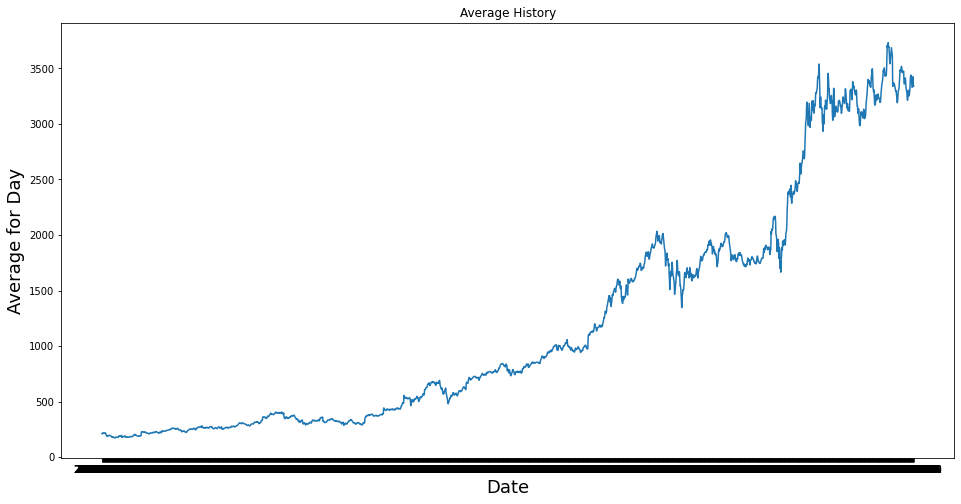

In [42]:
#Visualize Close Price
plt.figure(figsize=(16,8))
plt.title(compare_data + ' History')
plt.plot(df['Date'], df[compare_data])
plt.xlabel('Date', fontsize=18)
plt.ylabel(compare_data +' for Day', fontsize=18)
plt.show()

In [43]:
# create a new dataframe  with only the comapre_data column
data = df.filter([compare_data])
# convert the dataframe to a numpy array
dataset = data.values
# get the number of rows to train the LSTM model
training_data_len = math.ceil(len(dataset)*.80)


In [44]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [45]:
# Create the training dataset
# Create the scaled training dataset
train_data = scaled_data[0:training_data_len , :]
# split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
   x_train.append(train_data[i-60:i, 0])
   y_train.append(train_data[i, 0])

In [46]:
# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [47]:
#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1954, 60, 1)

In [48]:
# Build LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [49]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [50]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1954/1954 [==============================] - 54s 26ms/step - loss: 4.9416e-04


In [51]:
# Create testing dataset
# Create new array containing scaled values 
test_data = scaled_data[training_data_len - 60: , :]
# Create data set x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])
  

In [52]:
# Convert the data to a numpy array
x_test = np.array(x_test)

In [53]:
# Reshape data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(503, 60, 1)

In [54]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


In [55]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions- y_test)**2)
rmse

217.2547274944085

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


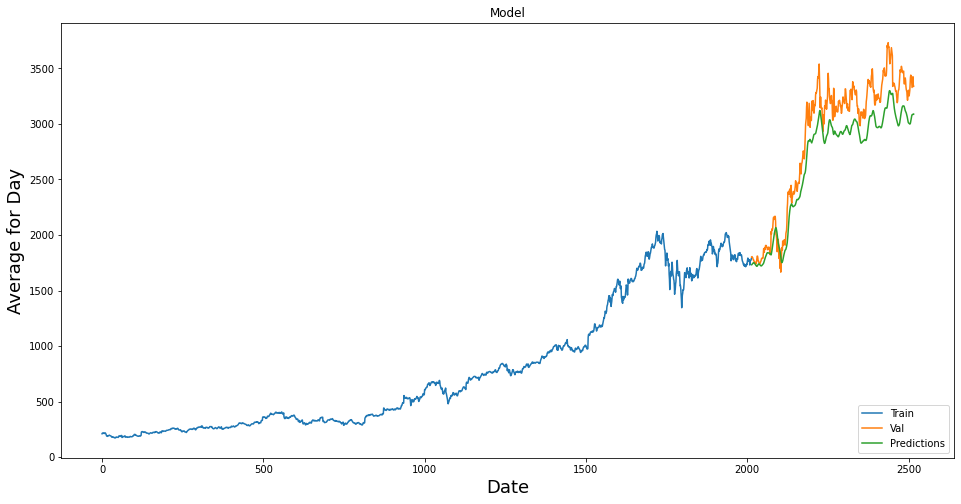

In [56]:
# Plot the date
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel(compare_data +' for Day', fontsize=18)
plt.plot(train[compare_data])
plt.plot(valid[[compare_data, 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [57]:
# Show the valid and predicted price
valid

,Average,Predictions
2014,1802.835022,1731.873291
2015,1805.434998,1735.803955
2016,1798.385010,1740.454590
2017,1795.979980,1744.621826
2018,1786.885010,1748.034546
...,...,...
2512,3362.790039,3083.785645
2513,3390.244995,3084.200684
2514,3424.335083,3085.596680
2515,3336.224976,3089.737305
